In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_periphery"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [4]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
p = 2
targets = np.array([197])
nontargets = np.array([220])

p_thr = 2/19
p_upper = 1

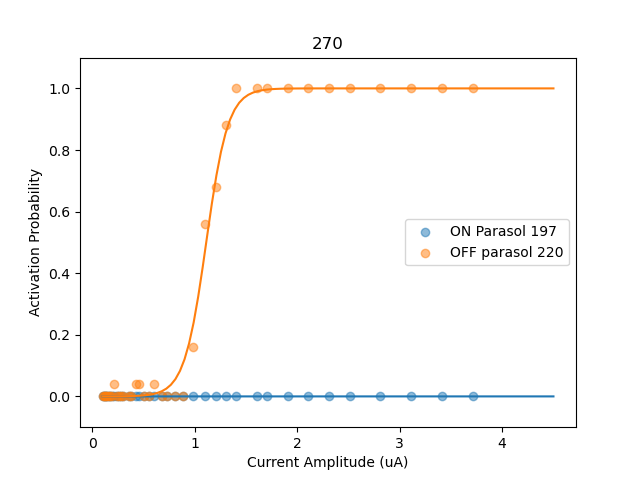

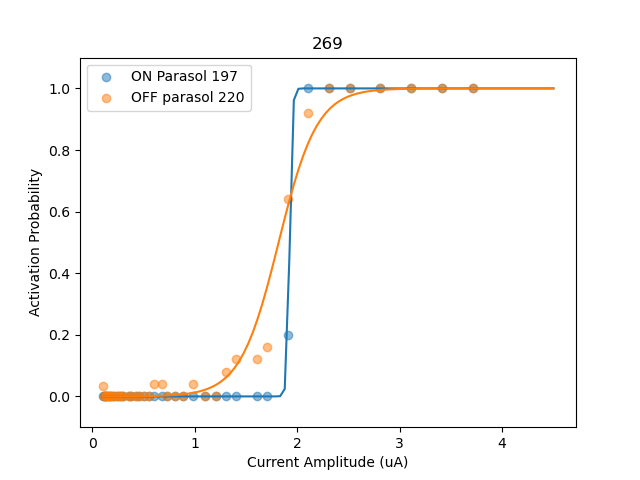

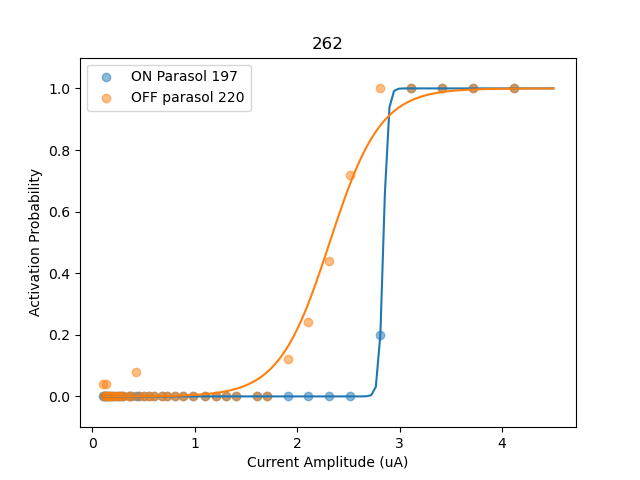

In [7]:
triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
all_cells = np.sort(np.concatenate((targets, nontargets)).astype(int))
all_signals = []

for elec in triplet_elecs:
    filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
    plt.figure()
    plt.title(str(elec))
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Activation Probability')
    plt.xlabel('Current Amplitude (uA)')
    
    cell_signals = []
    for cell in all_cells:
        k = 0
        probs = []
        trials = []
        signals = []
        while True:
            try:
                with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                    prob_dict = pickle.load(f)
                    probs.append(prob_dict["cosine_prob"][0])
                    trials.append(prob_dict["num_trials"])
                    electrode_list = prob_dict["electrode_list"]
                                        
                signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                      elec, k)[:,electrode_list,:55]
                signals.append(signal)
            except:
                break
            
            k += 1
        
        cell_signals.append(signals)
        trials = np.array(trials, dtype=int)
        probs = np.array(probs)

        if len(probs) > 0:    
            probs = fitting.disambiguate_sigmoid(probs, spont_limit = 0.15, noise_limit = 0.1)

            X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))
        
            results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))
        
            currs = np.linspace(0.1, 4.5, 100)
            plt.plot(currs, fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x))
            plt.scatter(Ivals[:k], probs, alpha=0.5, 
                        label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))
    
    plt.legend()
    
    all_signals.append(cell_signals)
        

In [10]:
def loadNewLVData(p, n):
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)
    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_newlv_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]
            trials[k] = prob_dict["num_trials"]

    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper) & (amplitudes[:, 0] < 1.5))[0]

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]
    T = trials[good_inds]

    return X, y, T

In [11]:
def binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=30, child=''):
    print(child)
    print(len(X))
    X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
    results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
    nll_MLE_init = fitting.negLL(results_init.x, X_bin_init, y_bin_init, False, 'none')
    print(nll_MLE_init)

    if len(X) >= min_points_per_cluster and nll_MLE_init < nll_thr:
        return [(X, y, results_init.x)]
    elif len(X) < min_points_per_cluster:
        return [(X, y, [np.nan])]
    else:
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]

   
        return binaryClustering(X[cluster0], y[cluster0], T[cluster0], nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, child='left') + binaryClustering(X[cluster1], y[cluster1], T[cluster1], nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, child='right') 


978
0.9890615489389118
left
598
0.9565531990921113
left
272
0.9120169393518812
left
189
0.8619551329476761
right
83
0.9105634768878718
left
52
0.870789370948676
right
31
0.8811009053131057
right
326
0.9351878798014387
left
152
0.8685944061502425
right
174
0.938257022499897
left
86
0.9129038825717121
left
36
0.9178715261728949
left
21
0.9204363602584259
right
15
0.8555684137019242
right
50
0.8340765883310186
right
88
0.8390956454902423
right
380
0.9527302820805021
left
269
0.8858633838668324
right
111
0.9494302855031305
left
56
0.9047273553186751
left
19
0.8922748429090832
right
37
0.8894130959649333
right
55
0.8619736886751849
[-14.57147646  -1.7381449   -8.93838843  -0.91714818]


/tmp/ipykernel_72348/830614029.py:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


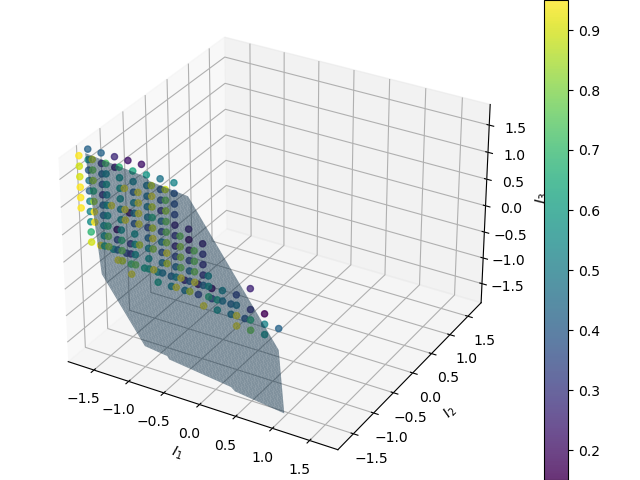

[-17.2740622   -2.08743765  -9.19411443   1.23972681]


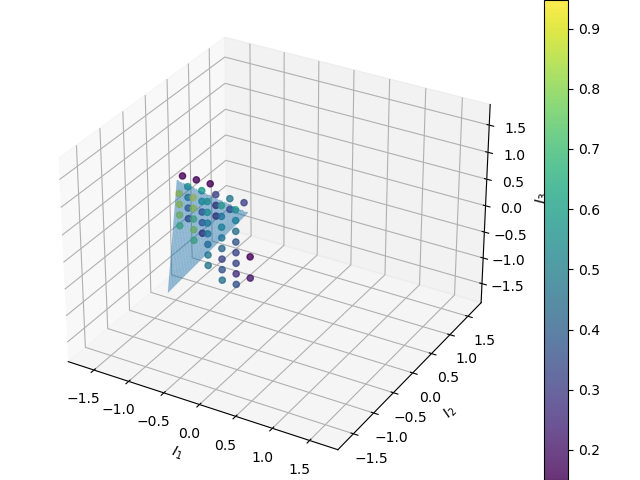

[-14.89553324   0.46107003  -4.87487699   3.54663174]


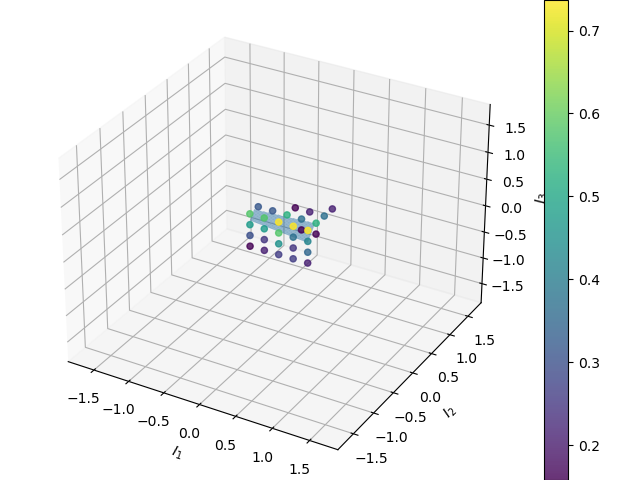

[-10.12421832  -1.40697734  -5.40602003  -4.53009034]


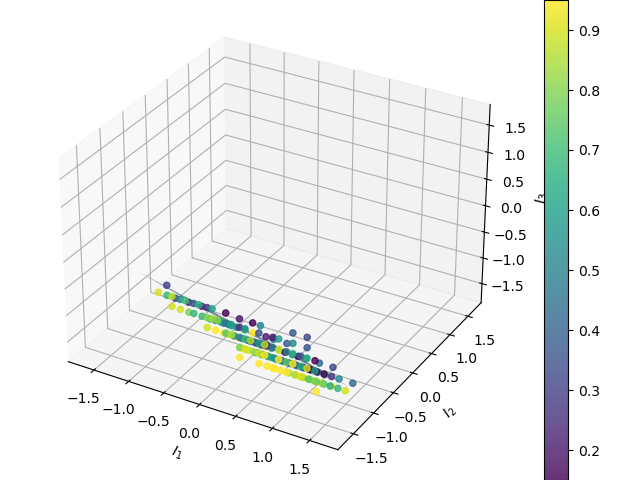

[nan]
[nan]
[-27.67995843  -2.65366312  -2.23051264 -14.65714493]


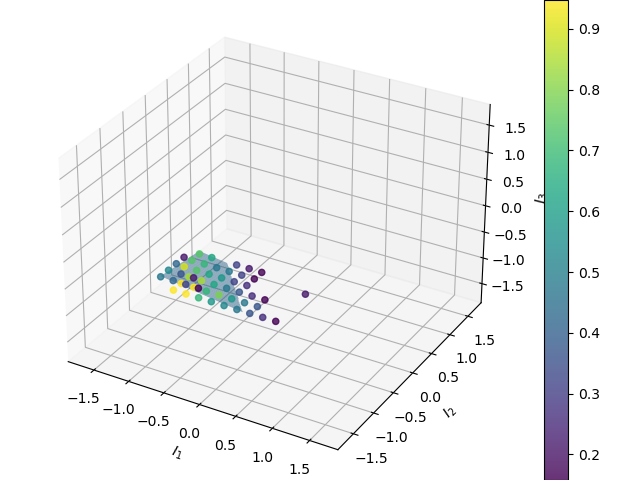

[-13.9641913   -1.93817849  -7.14832871  -7.04783362]


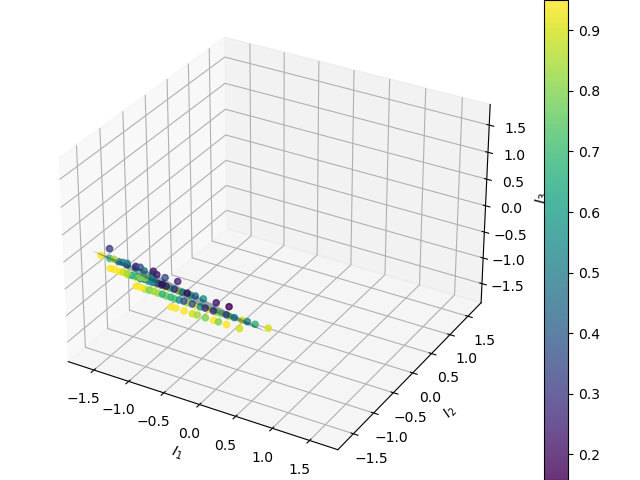

[-10.40524602   2.20164057   4.98515628   4.25407506]


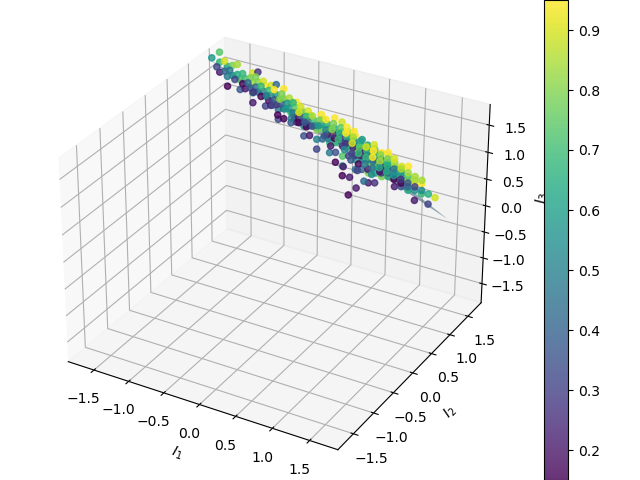

[nan]
[-17.44628597   2.11750048   6.99355593  -2.10809961]


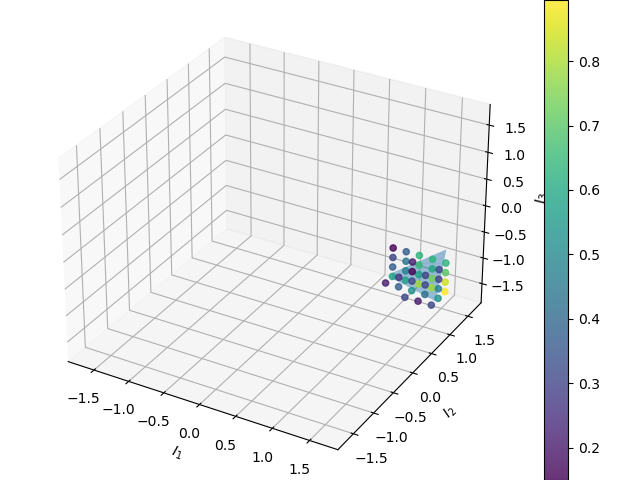

[-16.05888236   3.29894025   8.17951326   2.51767483]


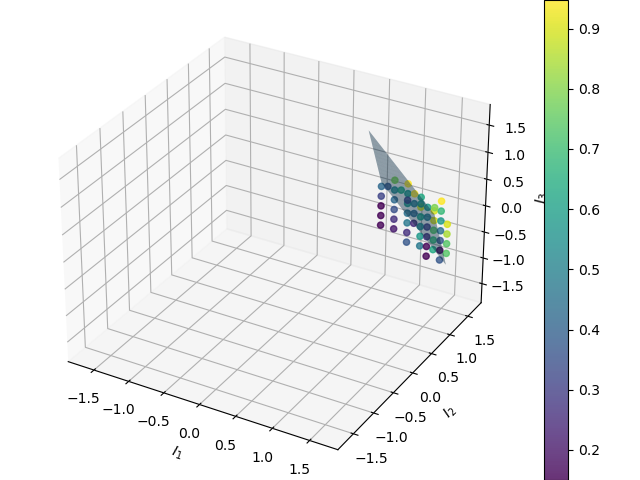

In [12]:
t_weights = []
t_amps = []
t_probs = []
for t in targets:
    X, y, T = loadNewLVData(p, t)
    t_amps.append(X)
    t_probs.append(y)
    output = binaryClustering(X, y, T)

    for i in range(len(output)):
        print(output[i][2])

        if len(output[i][2]) > 1:
            t_weights.append(output[i][2])
            normal = output[i][2][1:]

            d = output[i][2][0]
            xmin = np.amin(output[i][0][:, 0])
            xmax = np.amax(output[i][0][:, 0])
            ymin = np.amin(output[i][0][:, 1])
            ymax = np.amax(output[i][0][:, 1])

            # create x,y
            xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

            # calculate corresponding z
            z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
            z[z > 1.8] = np.nan
            z[z < -1.8] = np.nan

            # plot the surface
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            ax.plot_surface(xx, yy, z, alpha=0.5)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(output[i][0][:, 0], 
                        output[i][0][:, 1],
                        output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

            clb = plt.colorbar(scat)
            plt.show()

t_weights = np.vstack((t_weights))


1817
0.9987567798456128
left
866
0.8838910128938715
right
951
0.8855527090240448
[-4.81415417  3.98336477  2.07938665  1.95340058]


/tmp/ipykernel_72348/4096371890.py:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


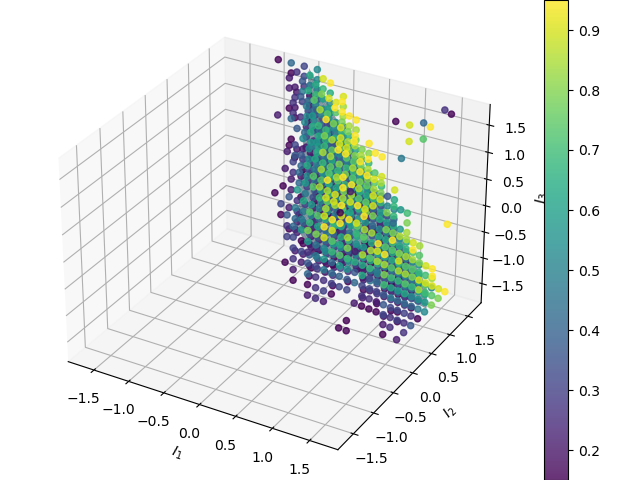

[-4.98070279 -4.82115632 -2.49694897 -2.39288679]


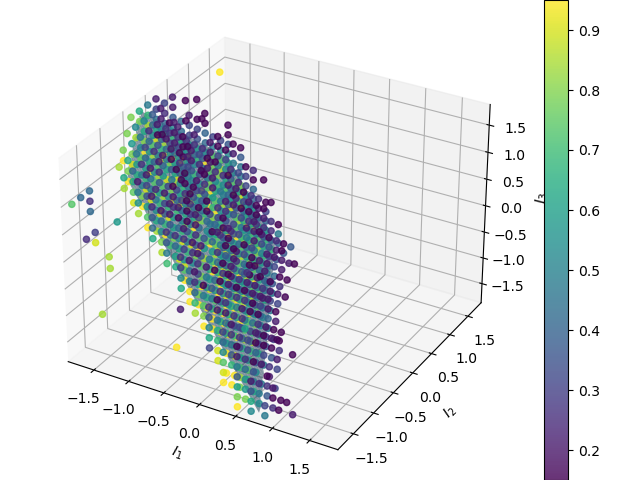

In [13]:
nt_weights = []
nt_amps = []
nt_probs = []
for nt in nontargets:
    X, y, T = loadNewLVData(p, nt)
    nt_amps.append(X)
    nt_probs.append(y)
    output = binaryClustering(X, y, T)

    for i in range(len(output)):
        print(output[i][2])

        if len(output[i][2]) > 1:
            nt_weights.append(output[i][2])
            normal = output[i][2][1:]

            d = output[i][2][0]
            xmin = np.amin(output[i][0][:, 0])
            xmax = np.amax(output[i][0][:, 0])
            ymin = np.amin(output[i][0][:, 1])
            ymax = np.amax(output[i][0][:, 1])

            # create x,y
            xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

            # calculate corresponding z
            z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
            z[z > 1.8] = np.nan
            z[z < -1.8] = np.nan

            # plot the surface
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            ax.plot_surface(xx, yy, z, alpha=0.5)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(output[i][0][:, 0], 
                        output[i][0][:, 1],
                        output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

            clb = plt.colorbar(scat)
            plt.show()

nt_weights = np.vstack((nt_weights))

In [ ]:
# def binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=30):
#     print(len(X))
#     X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
#     results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
#     nll_MLE_init = fitting.negLL(results_init.x, X_bin_init, y_bin_init, False, 'none')
#     print(nll_MLE_init)

#     if len(X) > min_points_per_cluster and nll_MLE_init < nll_thr:
#         return X, y, results_init.x

#     clustering = SpectralClustering(n_clusters=2, 
#                                     assign_labels='discretize',
#                                     affinity='nearest_neighbors').fit(X)

#     cluster0 = np.where(clustering.labels_ == 0)[0]
#     cluster1 = np.where(clustering.labels_ == 1)[0]

#     halves = [cluster0, cluster1]

#     for half in halves:
#         print(len(half))
#         X_cluster = X[half]
#         y_cluster = y[half]
#         trials_cluster = T[half]

#         X_bin, y_bin = fitting.convertToBinaryClassifier(y_cluster, trials_cluster, X_cluster)
#         results = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin, y_bin, False, 'none'))
#         nll_MLE = fitting.negLL(results.x, X_bin, y_bin, False, 'none')
#         print(nll_MLE)

#         if len(half) > min_points_per_cluster and nll_MLE < nll_thr:
#             return X_cluster, y_cluster, results.x

#         else:
#             try:
#                 return binaryClustering(X[half], y[half], T[half], nll_thr, min_points_per_cluster)
#             except:
#                 return [], [], []

In [ ]:
# def getPPWeights(p, n, num_restarts=10, nll_thr=0.9, min_points_per_cluster=30):
#     X, y, T = loadNewLVData(p, n)
#     remaining_inds = np.arange(len(X), dtype=int)

#     pp_weights = []
#     while len(remaining_inds) > 0:
#         for i in range(num_restarts):
#             output = binaryClustering(X[remaining_inds], y[remaining_inds], T[remaining_inds], 
#                                       nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster)
#             if i == 0:
#                 max_cluster = output

#             elif len(output[0]) > len(max_cluster[0]):
#                 max_cluster = output

#         if len(max_cluster[0]) == 0:
#             break

#         pp_weights.append(max_cluster[2])

#         fig = plt.figure()
#         fig.clear()
#         ax = Axes3D(fig)
#         plt.xlabel(r'$I_1$')
#         plt.ylabel(r'$I_2$')
#         plt.xlim(-1.8, 1.8)
#         plt.ylim(-1.8, 1.8)
#         ax.set_zlim(-1.8, 1.8)
#         ax.set_zlabel(r'$I_3$')

#         scat = ax.scatter(max_cluster[0][:, 0], 
#                           max_cluster[0][:, 1],
#                           max_cluster[0][:, 2], marker='o', s=20, c=max_cluster[1], alpha=0.8)

#         clb = plt.colorbar(scat)
#         plt.show()

#         idx = np.where(abs((X[:,np.newaxis,:] - max_cluster[0])).sum(axis=2)==0)[0]
#         remaining_inds = np.setdiff1d(remaining_inds, idx)

#         fig = plt.figure()
#         fig.clear()
#         ax = Axes3D(fig)
#         plt.xlabel(r'$I_1$')
#         plt.ylabel(r'$I_2$')
#         plt.xlim(-1.8, 1.8)
#         plt.ylim(-1.8, 1.8)
#         ax.set_zlim(-1.8, 1.8)
#         ax.set_zlabel(r'$I_3$')

#         scat = ax.scatter(X[remaining_inds, 0], 
#                     X[remaining_inds, 1],
#                     X[remaining_inds, 2], marker='o', s=20, c=y[remaining_inds], alpha=0.8)

#         clb = plt.colorbar(scat)
#         plt.show()

#     return np.array(pp_weights)

In [14]:
t_weights

array([[-14.57147646,  -1.7381449 ,  -8.93838843,  -0.91714818],
       [-17.2740622 ,  -2.08743765,  -9.19411443,   1.23972681],
       [-14.89553324,   0.46107003,  -4.87487699,   3.54663174],
       [-10.12421832,  -1.40697734,  -5.40602003,  -4.53009034],
       [-27.67995843,  -2.65366312,  -2.23051264, -14.65714493],
       [-13.9641913 ,  -1.93817849,  -7.14832871,  -7.04783362],
       [-10.40524602,   2.20164057,   4.98515628,   4.25407506],
       [-17.44628597,   2.11750048,   6.99355593,  -2.10809961],
       [-16.05888236,   3.29894025,   8.17951326,   2.51767483]])

In [15]:
nt_weights

array([[-4.81415417,  3.98336477,  2.07938665,  1.95340058],
       [-4.98070279, -4.82115632, -2.49694897, -2.39288679]])

In [16]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [17]:
I_max = 1.78125
selec_vals = np.zeros(len(t_weights))
x_vals = np.zeros((len(t_weights), 3))
for i in range(len(t_weights)):
    print(i)
    T_t = cp.Variable(1)
    T_n = cp.Variable(1)
    x = cp.Variable(3)

    constraints = [
        -t_weights[i, 0] - t_weights[i,1:] @ x  <= T_t,
        nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
        x[0] <= 1.4,
        -I_max <= x[0],
        x[1] <= I_max,
        -I_max <= x[1], 
        x[2] <= I_max,
        -I_max <= x[2],  
    ]

    objective_function = cp.exp(T_n) + cp.exp(T_t)

    objective = cp.Minimize(objective_function)
    prob = cp.Problem(objective, constraints)
    opt_val  = prob.solve()
    print(f"Optimal value {opt_val}")

    print(f"optimal p_t {compute_pt(T_t.value)[0]}")
    print(f"optimal p_n {compute_pn(T_n.value)[0]}")
    print(f"optimal T_t {T_t.value[0]}")
    print(f"optimal T_n {T_n.value[0]}")
    print(x.value)

    selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
    x_vals[i] = x.value

0
Optimal value 0.5344006468464424
optimal p_t 0.7179832325787979
optimal p_n 0.12404446679682612
optimal T_t -0.9344796877102854
optimal T_n -1.95467522394192
[ 1.17896869 -1.78125    -1.78124998]
1
Optimal value 0.17355288539136346
optimal p_t 0.8919702547156851
optimal p_n 0.049826406511514744
optimal T_t -2.111026176790201
optimal T_n -2.9480996031570417
[-0.38315337 -1.78124999  1.78124998]
2
Optimal value 0.7528890185759883
optimal p_t 0.5970920412605293
optimal p_n 0.07244686150056256
optimal T_t -0.39336312883785707
optimal T_n -2.54969673671771
[ 0.62481602 -1.78125     1.78125   ]
3
Optimal value 0.03804908020313001
optimal p_t 0.9870192929052951
optimal p_n 0.02429282392303838
optimal T_t -4.33122540075759
optimal T_n -3.692981521961161
[ 1.39999994 -1.78124945 -1.50013391]
4
Optimal value 1.5306989795090273
optimal p_t 0.5032012069710193
optimal p_n 0.3520892049661413
optimal T_t -0.012805002848871818
optimal T_n -0.6098684582000805
[ 0.90003006 -1.78124998 -1.78124999]
5
O

In [18]:
selec_vals

array([0.62892139, 0.84752658, 0.5538346 , 0.96304181, 0.32602949,
       0.97999152, 0.9155099 , 0.49054478, 0.40838383])

In [19]:
selec_vals[np.argsort(selec_vals)]

array([0.32602949, 0.40838383, 0.49054478, 0.5538346 , 0.62892139,
       0.84752658, 0.9155099 , 0.96304181, 0.97999152])

In [20]:
x_vals[np.argsort(selec_vals)]

array([[ 0.90003006, -1.78124998, -1.78124999],
       [-0.76256876,  1.78125   ,  1.78125   ],
       [ 0.85099596,  1.78125   , -1.78125   ],
       [ 0.62481602, -1.78125   ,  1.78125   ],
       [ 1.17896869, -1.78125   , -1.78124998],
       [-0.38315337, -1.78124999,  1.78124998],
       [-1.45744568,  1.78124993,  1.78124992],
       [ 1.39999994, -1.78124945, -1.50013391],
       [ 1.39999994, -1.31085262, -1.78124678]])

In [21]:
selec_vec = x_vals[np.argsort(selec_vals)[-1]]

/tmp/ipykernel_72348/750019906.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


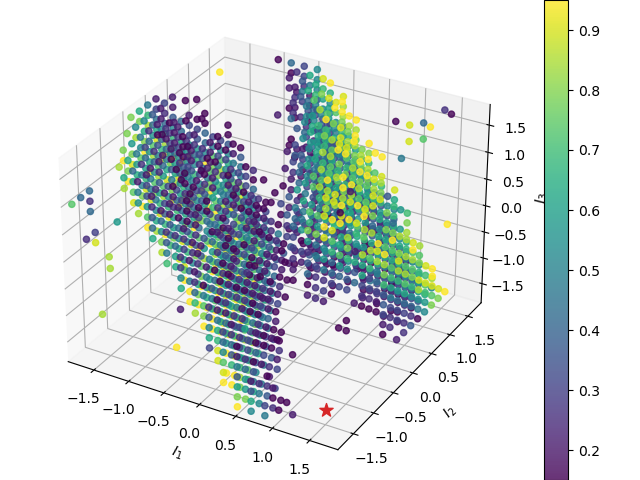

In [22]:
for i in range(len(nt_amps)):
    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(nt_amps[i][:, 0], 
                nt_amps[i][:, 1],
                nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

    ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()

/tmp/ipykernel_72348/4199416486.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


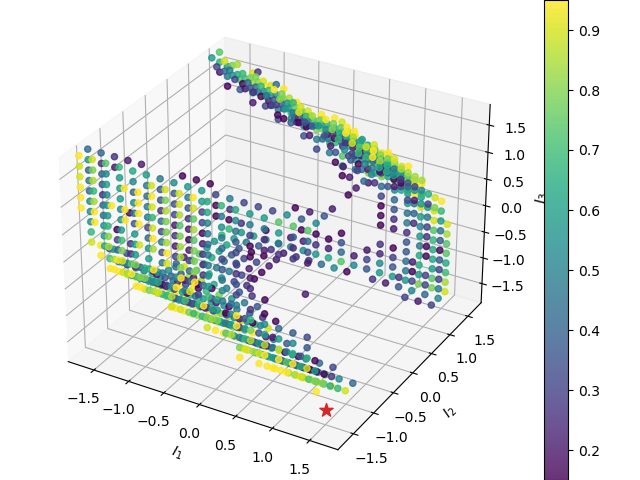

In [23]:
for i in range(len(t_amps)):
    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(t_amps[i][:, 0], 
                t_amps[i][:, 1],
                t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

    ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()